In [1]:
import os
import pickle
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch
import torchvision

#### Loading data

In [107]:
with open('./data/latest_states.data', 'rb') as f:
    latents = pickle.load(f)
    
with open('./data/rewards.data', 'rb') as f:
    rewards = pickle.load(f)
    
with open('./data/full_states_0.data', 'rb') as f:
    fulls = pickle.load(f)

In [108]:
scaled_rewards = []

for i in range(len(rewards)):
    scaled_rewards.append(
        [x if x <10 else 1 for x in rewards[i]]
    )

In [54]:
pca = PCA(3)

In [57]:
x = pca.fit_transform(np.array(latents[0]))

In [58]:
type(fulls[0])

numpy.ndarray

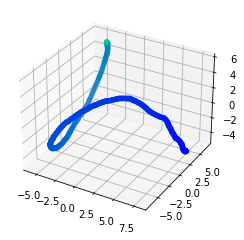

In [59]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
# plt.title('PCA: Hidden Space of Random Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards[0], cmap='winter')

#### Model

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 16, (5,5), 2)
        self.c2 = nn.Conv2d(16, 8, (5,5), 2)
        self.c3 = nn.Conv2d(8, 1, (5, 5), 2)
        self.d1 = nn.Linear(625, 32)
        
    def single_forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        return self.d1(x)
    
    def forward(self, xs):
        x1 = self.single_forward(xs[0])
        x2 = self.single_forward(xs[1])
        return x1, x2
 
class PolicyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(3, 8, (3, 3), stride=2)
        self.c2 = nn.Conv2d(8, 4, (3, 3), stride=2)
        self.c3 = nn.Conv2d(4, 1, (3, 3), stride=2)
        self.d1 = nn.Linear(729, 64)

        self.action_head = nn.Linear(64, 7)
        self.value_head = nn.Linear(64, 1)

        # action & reward buffer
        self.saved_actions = []
        self.rewards = []
    
    def base(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        return self.d1(x)
    
    def siamese(self, xs):
        out1 = self.base(xs[0])
        out2 = self.base(xs[1])
        return out1, out2
    
    def forward(self, x):
        x = F.relu(self.c1(x))
        x = F.relu(self.c2(x))
        x = F.relu(self.c3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.d1(x))


        # actor: choses action to take from state s_t
        # by returning probability of each action
        action_prob = F.softmax(self.action_head(x), dim=-1)

        # critic: evaluates being in the state s_t
        state_values = self.value_head(x)

        # return values for both actor and critic as a tupel of 2 values:
        # 1. a list with the probability of each action over the action space
        # 2. the value from state s_t
        return action_prob, state_values


In [109]:
model = PolicyCNN()

rnd_model = PolicyCNN()
# rnd_model.load_state_dict(model.state_dict())

#### Loss function

In [110]:
class ManhattanLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, out1, out2, rs):
        l1 = F.pairwise_distance(out1, out2, 1)
        return torch.mean((l1 - rs)**2)

In [111]:
loss_fn = ManhattanLoss()

In [112]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#### Training

In [143]:
MBS = 100
batch_size = 32
# loss_hist = []

for i in tqdm(range(MBS)):
    idxs = [np.random.choice(len(rewards[0])-2, 2, replace=False) for _ in range(batch_size)]
    rs = np.array(scaled_rewards[0])[idxs]
    rs = torch.tensor(np.abs(rs[:,0] - rs[:,1])).float()
    xs = np.array(fulls)[idxs]
    xs = torch.tensor(np.moveaxis(xs, -1, 2)).float()
    x1 = xs[:, 0, :, :, :]
    x2 = xs[:, 1, :, :, :]
    out1, out2 = model.siamese([x1, x2])
    
    loss = loss_fn(out1, out2, rs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


(0.0, 0.1)

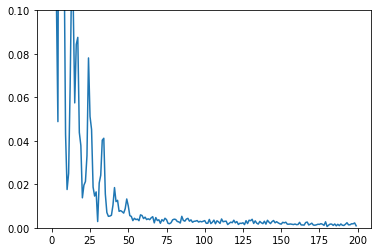

In [144]:
plt.plot(loss_hist)
plt.ylim(0.0, 0.1)

In [145]:
F.pairwise_distance(out1, out2, 1)

tensor([1.3528, 2.4219, 1.0679, 0.9367, 2.1640, 2.4320, 1.1703, 0.1541, 1.3518,
        3.3186, 0.9702, 1.5796, 2.5357, 3.0155, 0.5265, 0.5770, 2.7814, 1.0446,
        2.8290, 0.4231, 1.1584, 1.7323, 0.1337, 1.5659, 1.3430, 1.4225, 1.6075,
        2.4557, 0.6322, 0.5331, 1.5404, 1.4933], grad_fn=<NormBackward1>)

In [146]:
rs

tensor([1.3459, 2.4357, 1.1038, 0.9078, 2.1963, 2.4294, 1.1508, 0.1016, 1.3274,
        3.3334, 0.9316, 1.5868, 2.5834, 3.0657, 0.5305, 0.5242, 2.7895, 0.9801,
        2.8418, 0.4029, 1.1705, 1.7632, 0.1498, 1.5828, 1.3424, 1.4132, 1.5819,
        2.4840, 0.5908, 0.4862, 1.5427, 1.4589])

In [147]:
outs = []
outs_rnd = []
for i in tqdm(range(len(fulls))):
    img = np.moveaxis(fulls[i], -1, 0)
    img = torch.tensor(img).unsqueeze(0).float()
    out = model.base(img)
    outs.append(out.detach().numpy()[0])
    
    out_rnd = rnd_model.base(img)
    outs_rnd.append(out_rnd.detach().numpy()[0])

100%|██████████| 488/488 [00:01<00:00, 403.34it/s]


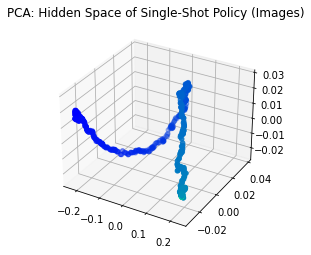

In [128]:
pca = PCA(3)
x = pca.fit_transform(np.array(outs))
fig = plt.figure()
ax = plt.axes(projection ='3d')
plt.title('PCA: Hidden Space of Single-Shot Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards[0], cmap='winter')

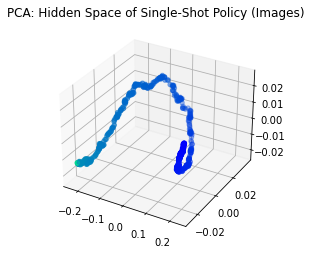

In [148]:
pca = PCA(3)
x = pca.fit_transform(np.array(outs))
fig = plt.figure()
ax = plt.axes(projection ='3d')
plt.title('PCA: Hidden Space of Single-Shot Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards[0], cmap='winter')

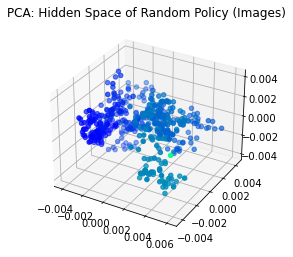

In [130]:
pca = PCA(3)
x = pca.fit_transform(np.array(outs_rnd))
fig = plt.figure()
ax = plt.axes(projection ='3d')
plt.title('PCA: Hidden Space of Random Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards[0], cmap='winter')

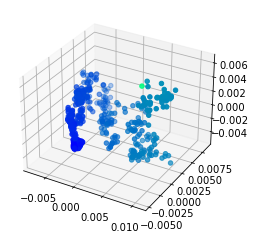

In [68]:
pca = PCA(3)
x = pca.fit_transform(np.array(outs_rnd))
fig = plt.figure()
ax = plt.axes(projection ='3d')
# plt.title('PCA: Hidden Space of Random Policy (Images)')
ax.scatter(xs=x[:, 0], 
           ys=x[:, 1], 
           zs=x[:, 2], 
           c=scaled_rewards[0], cmap='winter')

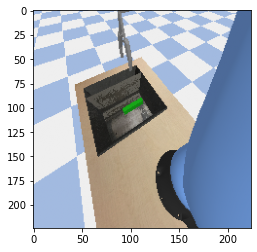

In [103]:
plt.imshow(fulls[0])

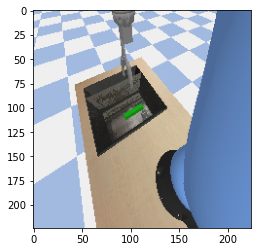

In [106]:
plt.imshow(fulls[88])

In [149]:
torch.save(model.state_dict(), './data/200_fewshot_0.pth')

In [125]:
model.load_state_dict(torch.load('./data/100_fewshot_0.pth'))
model.state_dict()

OrderedDict([('c1.weight',
              tensor([[[[-0.0433,  0.1116, -0.0376],
                        [ 0.1452, -0.0819, -0.0624],
                        [ 0.1865,  0.1034, -0.1185]],
              
                       [[-0.0889,  0.0283,  0.0902],
                        [ 0.1812, -0.0476,  0.1102],
                        [ 0.0226, -0.1471,  0.0833]],
              
                       [[-0.0169,  0.1405, -0.0966],
                        [-0.1883,  0.1724, -0.0310],
                        [-0.1433, -0.0364, -0.1696]]],
              
              
                      [[[-0.1358, -0.0038, -0.0101],
                        [ 0.0297,  0.1351,  0.1799],
                        [-0.0790,  0.0606,  0.1781]],
              
                       [[ 0.1192,  0.1675, -0.0075],
                        [-0.0932, -0.1230,  0.1053],
                        [ 0.0773,  0.0365, -0.0221]],
              
                       [[ 0.1456, -0.1461,  0.0829],
                        [-0.1

In [131]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[[[-0.0433,  0.1116, -0.0376],
          [ 0.1452, -0.0819, -0.0624],
          [ 0.1865,  0.1034, -0.1185]],

         [[-0.0889,  0.0283,  0.0902],
          [ 0.1812, -0.0476,  0.1102],
          [ 0.0226, -0.1471,  0.0833]],

         [[-0.0169,  0.1405, -0.0966],
          [-0.1883,  0.1724, -0.0310],
          [-0.1433, -0.0364, -0.1696]]],


        [[[-0.1358, -0.0038, -0.0101],
          [ 0.0297,  0.1351,  0.1799],
          [-0.0790,  0.0606,  0.1781]],

         [[ 0.1192,  0.1675, -0.0075],
          [-0.0932, -0.1230,  0.1053],
          [ 0.0773,  0.0365, -0.0221]],

         [[ 0.1456, -0.1461,  0.0829],
          [-0.1269, -0.1228,  0.0902],
          [-0.0332, -0.1701,  0.1638]]],


        [[[ 0.1639,  0.1483,  0.0567],
          [ 0.1472,  0.1241, -0.1530],
          [ 0.1098,  0.0201, -0.0233]],

         [[ 0.0644,  0.0283, -0.1188],
          [-0.0275,  0.0704,  0.1928],
          [-0.0596, -0.0300, -0.1340]],

         [[ 0.0956,  0

In [136]:
model

PolicyCNN(
  (c1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2))
  (c2): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2))
  (c3): Conv2d(4, 1, kernel_size=(3, 3), stride=(2, 2))
  (d1): Linear(in_features=729, out_features=64, bias=True)
  (action_head): Linear(in_features=64, out_features=7, bias=True)
  (value_head): Linear(in_features=64, out_features=1, bias=True)
)